In [ ]:
!pip install tensorflow==2.7.0

In [ ]:
import pandas as pd
import numpy as np
import io
from google.colab import files
# tornar valores numpy mais fáceis de ler
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [ ]:
# enviar dados em .csv
data = files.upload()

Saving data.csv to data.csv


In [ ]:
df = pd.read_csv(io.StringIO(data['data.csv'].decode('utf-8')))
df.head

<bound method NDFrame.head of     diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0           M        17.99         10.38          122.80     1001.0   
1           M        20.57         17.77          132.90     1326.0   
2           M        19.69         21.25          130.00     1203.0   
3           M        11.42         20.38           77.58      386.1   
4           M        20.29         14.34          135.10     1297.0   
..        ...          ...           ...             ...        ...   
564         M        21.56         22.39          142.00     1479.0   
565         M        20.13         28.25          131.20     1261.0   
566         M        16.60         28.08          108.30      858.1   
567         M        20.60         29.33          140.10     1265.0   
568         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0            0.11840           0.27760

In [ ]:
# análise dos tipos de dados
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave_points_worst

In [ ]:
# definir objeto diag
diagnosis = df.diagnosis
# colocar diag no fim da tabela
df.drop('diagnosis', axis = 1, inplace = True)
df['diagnosis'] = diagnosis
df.head()

# descobrir qual a média de diagnósticos e mapear os strings para int (malígno - 1 ou benigno - 0 ?):
diagnosis_coder = {'M':1, 'B':0}
df.diagnosis = df.diagnosis.map(diagnosis_coder)
avgdiag = df["diagnosis"].mean()
df.head

nben = (df['diagnosis']==0).sum()
nmal=  (df['diagnosis']==1).sum()
ntot = ((df['diagnosis']==0).sum())+((df['diagnosis']==1).sum())

percben = (nben/ntot)*100
percmal = (nmal/ntot)*100

print(df['diagnosis'].value_counts())
print(ntot)
print(avgdiag)
print(percben)
print(percmal)


0    357
1    212
Name: diagnosis, dtype: int64
569
0.37258347978910367
62.741652021089635
37.258347978910365


In [ ]:
# separar os dados iniciais em 3 data sets (dados de treino, dados de validação e dados de teste)
#lembrar: features são os inputs, labels são os targets     x = features,  y = targets

# validação
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

from sklearn.preprocessing import Normalizer

# teste e treino - usar 80% para treino

# obs: x train = df_features y train = df_labels
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df['diagnosis'], train_size = .8 )

# normalização
norm = Normalizer()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [ ]:
#df_features = train.copy()
#df_labels = df_features.pop('diagnosis')
#df_labels = df_labels/avgdiag

val_features = val.copy()
val_labels = val.pop('diagnosis')
val_labels = val_labels/avgdiag

#test_features = test.copy()
#test_labels = test.pop('diagnosis')
#test_labels = test/avgdiag

Número optimizado de estimadores: dict_values([100])
Acurácia do modelo nos dados de teste: 0.9210526315789473


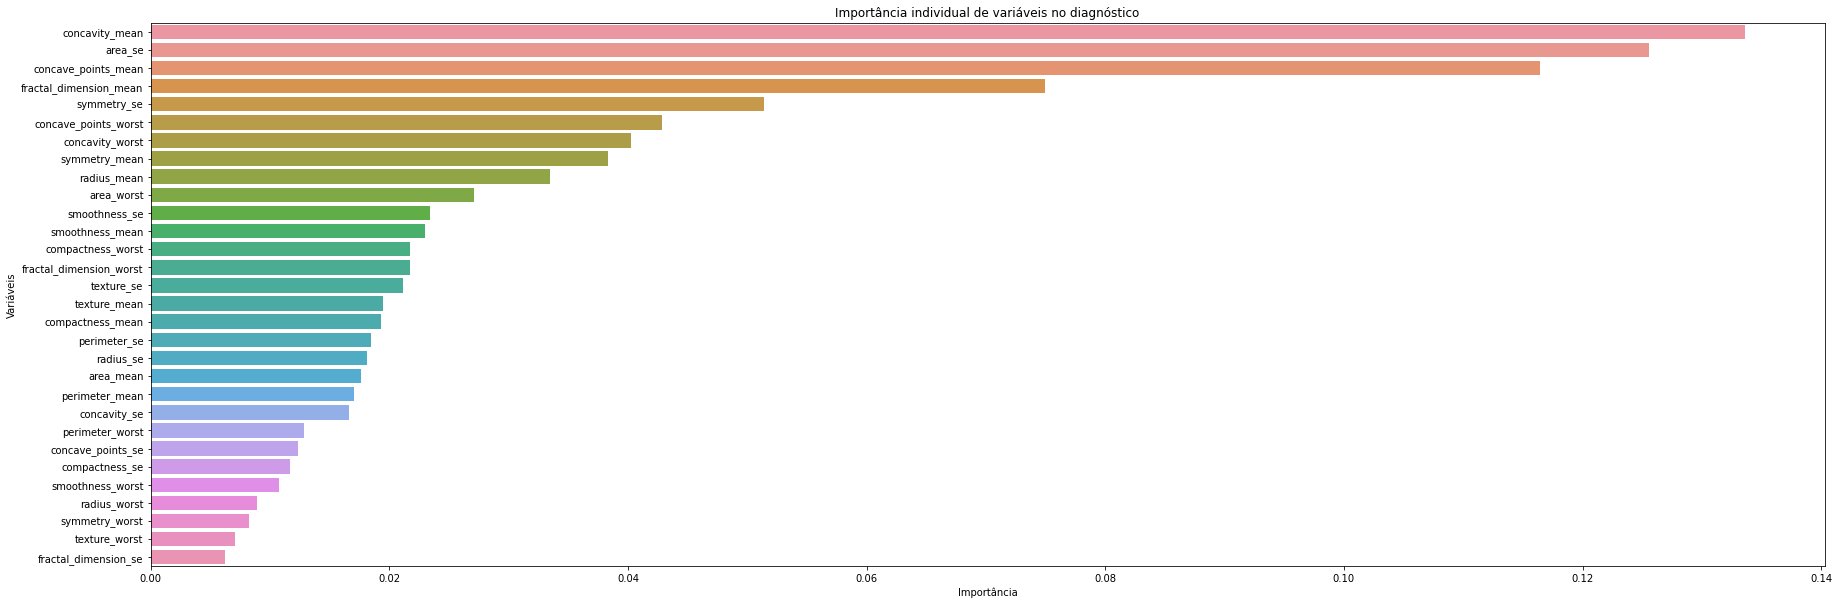

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Parameters
RF_params = {'n_estimators':[10,50,100, 200]}

# Instantiate RFC
RFC_2 = RandomForestClassifier(random_state=42)

# Instantiate gridsearch using RFC model and dictated parameters
RFC_2_grid = GridSearchCV(RFC_2, RF_params)

# Fit model to training data
RFC_2_grid.fit(X_train_norm, y_train)

# Print best parameters
print('Número optimizado de estimadores: {}'.format(RFC_2_grid.best_params_.values()))
# Train RFC on whole training set

# Instantiate RFC with optimal parameters
RFC_3 = RandomForestClassifier(n_estimators=50, random_state=42)

# Fit RFC to training data
RFC_3.fit(X_train_norm, y_train)

# Predict on training data using fitted RFC

# Evalaute RFC with test data
RFC_3_predicted = RFC_3.predict(X_test_norm)
print('Acurácia do modelo nos dados de teste: {}'.format(accuracy_score(y_test, RFC_3_predicted)))
# Create dataframe by zipping RFC feature importances and column names
rfc_features = pd.DataFrame(zip(RFC_3.feature_importances_, df.columns[:-1]), columns = ['Importância', 'Variáveis'])

# Sort in descending order for easy organization and visualization
rfc_features = rfc_features.sort_values(['Importância'], ascending=False)
# Visualize RFC feature importances
sns.barplot(x = 'Importância', y = 'Variáveis', data = rfc_features, )
plt.title('Importância individual de variáveis no diagnóstico')
sns.set_style("whitegrid")
plt.gcf().set_size_inches(30,10)
plt.show()

In [ ]:
# remover variáveis menos revelantes

X_train.drop('fractal_dimension_se', axis=1, inplace=True)
X_train.drop('texture_worst', axis=1, inplace=True)
X_train.drop('symmetry_worst', axis=1, inplace=True)
X_train.drop('radius_worst', axis=1, inplace=True)
X_train.drop('smoothness_worst', axis=1, inplace=True)
X_train.drop('compactness_se', axis=1, inplace=True)
X_train.drop('concave_points_se', axis=1, inplace=True)
X_train.drop('perimeter_worst', axis=1, inplace=True)
X_train.drop('concavity_se', axis=1, inplace=True)
X_train.drop('perimeter_mean', axis=1, inplace=True)
X_train.drop('area_mean', axis=1, inplace=True)
X_train.drop('radius_se', axis=1, inplace=True)
X_train.drop('perimeter_se', axis=1, inplace=True)
X_train.drop('compactness_mean', axis=1, inplace=True)
X_train.drop('texture_mean', axis=1, inplace=True)
X_train.drop('texture_se', axis=1, inplace=True)
X_train.drop('fractal_dimension_worst', axis=1, inplace=True)
X_train.drop('compactness_worst', axis=1, inplace=True)
X_train.drop('smoothness_mean', axis=1, inplace=True)
X_train.drop('smoothness_se', axis=1, inplace=True)

val_features.drop('fractal_dimension_se', axis=1, inplace=True)
val_features.drop('texture_worst', axis=1, inplace=True)
val_features.drop('symmetry_worst', axis=1, inplace=True)
val_features.drop('radius_worst', axis=1, inplace=True)
val_features.drop('smoothness_worst', axis=1, inplace=True)
val_features.drop('compactness_se', axis=1, inplace=True)
val_features.drop('concave_points_se', axis=1, inplace=True)
val_features.drop('perimeter_worst', axis=1, inplace=True)
val_features.drop('concavity_se', axis=1, inplace=True)
val_features.drop('perimeter_mean', axis=1, inplace=True)
val_features.drop('area_mean', axis=1, inplace=True)
val_features.drop('radius_se', axis=1, inplace=True)
val_features.drop('perimeter_se', axis=1, inplace=True)
val_features.drop('compactness_mean', axis=1, inplace=True)
val_features.drop('texture_mean', axis=1, inplace=True)
val_features.drop('texture_se', axis=1, inplace=True)
val_features.drop('fractal_dimension_worst', axis=1, inplace=True)
val_features.drop('compactness_worst', axis=1, inplace=True)
val_features.drop('smoothness_mean', axis=1, inplace=True)
val_features.drop('smoothness_se', axis=1, inplace=True)

In [ ]:
# construção do modelo usando keras
inputs = {}

for name, column in X_train.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'radius_mean': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'radius_mean')>,
 'concavity_mean': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'concavity_mean')>,
 'concave_points_mean': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'concave_points_mean')>,
 'symmetry_mean': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'symmetry_mean')>,
 'fractal_dimension_mean': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fractal_dimension_mean')>,
 'area_se': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'area_se')>,
 'symmetry_se': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'symmetry_se')>,
 'area_worst': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'area_worst')>,
 'concavity_worst': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'concavity_worst')>,
 'concave_points_worst': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'concave_poi

In [ ]:
# pré-processamento - normalização
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
#x = list(numeric_inputs.values())
norm = preprocessing.Normalization()
norm.adapt(np.array(df[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'normalization')>

In [ ]:
# Coletar todos resultados de preprocessamento, para concatenar-los depois.
preprocessed_inputs = [all_numeric_inputs]

In [ ]:
# transformação dos dados de entrada
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = preprocessing.StringLookup(vocabulary=np.unique(X_train[name]))
  one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

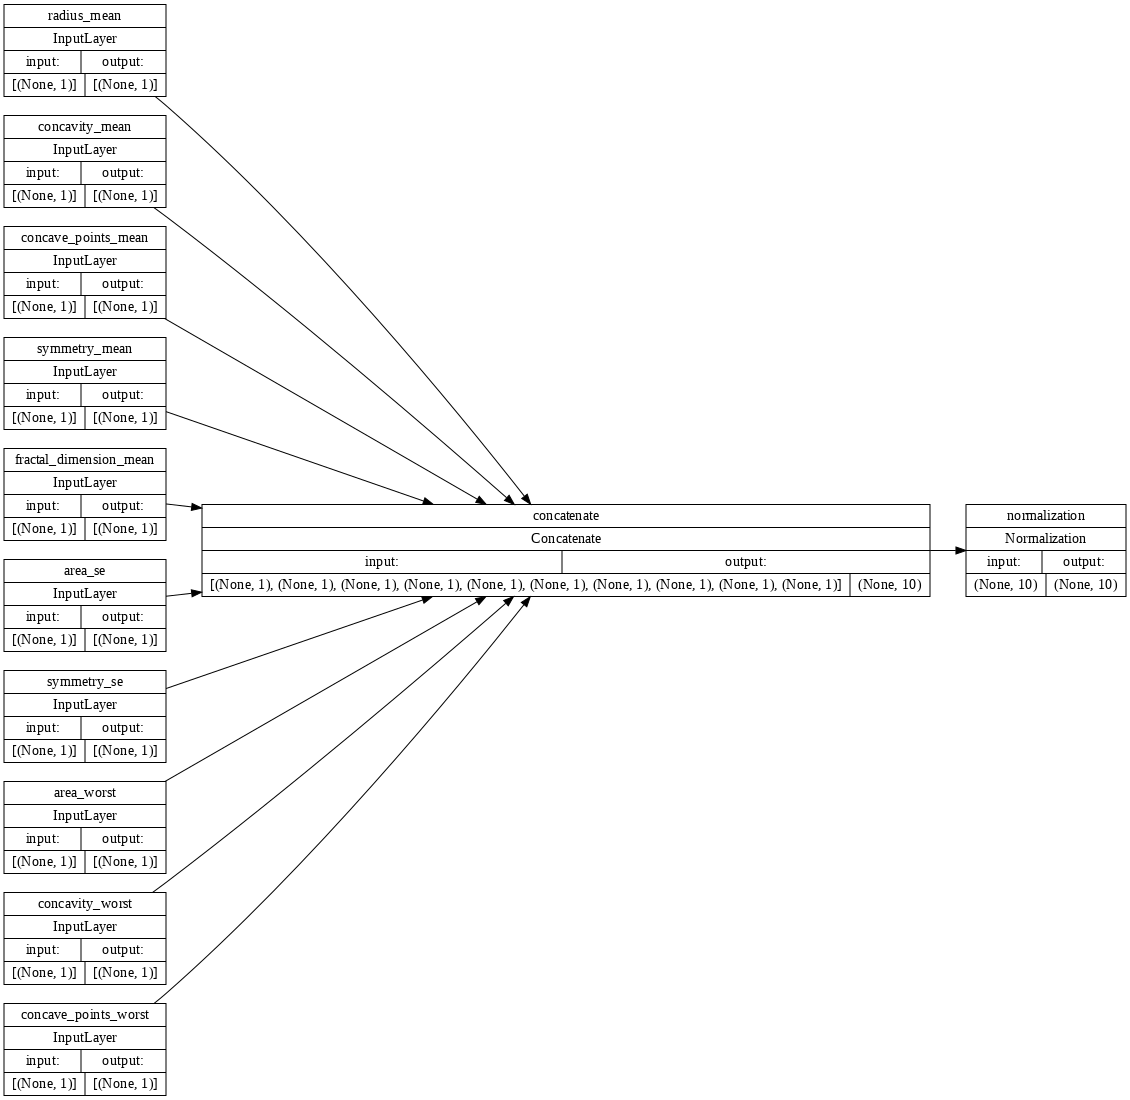

In [ ]:
df_preprocessing = tf.keras.Model(inputs, preprocessed_inputs)
tf.keras.utils.plot_model(model = df_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [ ]:
# Converter o model para um dicionário de tensors:
df_features_dict = {name: np.array(value) 
                         for name, value in X_train.items()}

In [ ]:
# Rodar dados de amostra pelo preprocessamento para validação dos resultados
features_dict = {name:values[:1] for name, values in df_features_dict.items()}
df_preprocessing(features_dict)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.286, -0.21 , -0.146, -0.312, -0.112, -0.194, -0.101, -0.503,
        -0.233, -0.22 ]], dtype=float32)>

In [ ]:
# construção do modelo para predições
def df_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'accuracy'])
  return model

df_model = df_model(df_preprocessing, inputs)

In [ ]:
val_features_dict = {name: np.array(value) 
                         for name, value in val.items()}
history_1 = df_model.fit(x=df_features_dict, y=y_train,epochs=250,
                        validation_data=(val_features_dict, val_labels))

Epoch 1/250
15/15 [==============================] - 1s 26ms/step - loss: 0.2978 - mae: 0.4081 - accuracy: 0.6901 - val_loss: 1.6064 - val_mae: 0.8627 - val_accuracy: 0.6154
Epoch 2/250
 1/15 [=>............................] - ETA: 0s - loss: 0.1861 - mae: 0.3346 - accuracy: 0.7812

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'radius_se', 'texture_se', 'perimeter_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'smoothness_worst', 'compactness_worst', 'symmetry_worst', 'fractal_dimension_worst'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/15 [==============================] - 0s 6ms/step - loss: 0.1382 - mae: 0.2733 - accuracy: 0.8418 - val_loss: 1.4361 - val_mae: 0.7963 - val_accuracy: 0.6154
Epoch 3/250
15/15 [==============================] - 0s 6ms/step - loss: 0.1172 - mae: 0.2372 - accuracy: 0.8945 - val_loss: 1.3944 - val_mae: 0.7743 - val_accuracy: 0.6154
Epoch 4/250
15/15 [==============================] - 0s 6ms/step - loss: 0.1064 - mae: 0.2200 - accuracy: 0.9055 - val_loss: 1.3404 - val_mae: 0.7637 - val_accuracy: 0.6154
Epoch 5/250
15/15 [==============================] - 0s 7ms/step - loss: 0.0955 - mae: 0.2079 - accuracy: 0.9143 - val_loss: 1.3230 - val_mae: 0.7641 - val_accuracy: 0.6154
Epoch 6/250
15/15 [==============================] - 0s 6ms/step - loss: 0.0908 - mae: 0.1945 - accuracy: 0.9165 - val_loss: 1.3047 - val_mae: 0.7535 - val_accuracy: 0.6154
Epoch 7/250
15/15 [==============================] - 0s 7ms/step - loss: 0.0880 - mae: 0.1864 - accuracy: 0.9121 - val_loss: 1.3155 - val_mae: 0.76

1/1 [==============================] - 0s 170ms/step - loss: 0.0510 - mae: 0.1188 - accuracy: 0.9275
test loss, test acc: [0.050963833928108215, 0.11881297826766968, 0.9274725317955017]


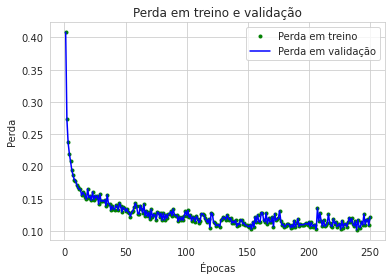

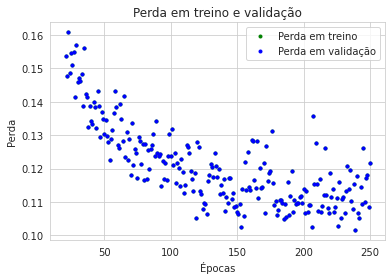

In [ ]:
# Pós-treino, visualização dos resultados
# acurácia de predição:  
#lembrar: features são os inputs, labels são os targets     x = features,  y = targets
results = df_model.evaluate(df_features_dict, y_train, batch_size=1024)
print("test loss, test acc:", results)

# exibir um gráfico da perda, que é a distância entre os valores previstos e os reais durante o treino e validação
import matplotlib.pyplot as plt
# Usar a métrica de modelagem MAE
train_loss = history_1.history['mae']
val_loss = history_1.history['mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Perda em treino')
plt.plot(epochs, val_loss, 'b', label='Perda em validação')
plt.title('Perda em treino e validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Excluir as primeiras épocas para tornar o gráfico mais fácil de ler
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Perda em treino')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Perda em validação')
plt.title('Perda em treino e validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [ ]:
# Salvar o modelo para uso depois em forma de pacote
df_model.save('test')
reloaded = tf.keras.models.load_model('test')

In [ ]:
!zip -r test.zip test

  adding: test/ (stored 0%)
  adding: test/saved_model.pb (deflated 90%)
  adding: test/variables/ (stored 0%)
  adding: test/variables/variables.index (deflated 63%)
  adding: test/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: test/keras_metadata.pb (deflated 95%)
  adding: test/assets/ (stored 0%)
